# ***Dataset Thresholding***

This notebook shows the thresholding of the dataset. We apply thresholding
to an MSI in order to separate tissue spectra's from all spectra's.

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import os
import numpy as np
from skimage import filters
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
from typing import Tuple
from pathlib import Path

%matplotlib inline

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../../../DHG/"
# Define folder that contains the dataset
DATA_IN_PATH = f"{DHG_PATH}/preprocessed"
# Define path to save plots
PLOTS_OUT_PATH = "thresholding"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150

### ***Creating output folder***

Next, let's create the output folder:

In [3]:
# Create output folder if doesn't exist
Path(PLOTS_OUT_PATH).mkdir(parents=True, exist_ok=True)

### ***Define function to try all treshould methods***

Next, let's define a function to try all treshould methods on given image:

In [4]:
def try_all_threshold(
    img: np.ndarray, figsize: Tuple[int, int]
) -> Tuple[plt.Figure, np.ndarray]:
  """ Function to return a figure comparing the outputs of different
  thresholding methods.
  
  Args:
    img (np.ndarray): Grayscale input image.
    figsize (Tuple[int, int]): Figure size (in inches).
    
  Returns:
    [Tuple[plt.Figure, np.ndarray]]: Matplotlib figure and axes.
  
  """
  # create subplot
  fig, axes = plt.subplots(ncols=9, sharex=True, sharey=True, figsize=figsize)

  img = filters.gaussian(img, sigma=0.5)

  # add each subplot
  axes[0].imshow(img, cmap='viridis')
  axes[0].set_title('Original')

  axes[1].imshow(img > filters.threshold_isodata(img), cmap=plt.cm.gray)
  axes[1].set_title('Isodata')

  axes[2].imshow(img > filters.threshold_li(img), cmap=plt.cm.gray)
  axes[2].set_title('Li')

  axes[3].imshow(img > filters.threshold_mean(img), cmap=plt.cm.gray)
  axes[3].set_title('Mean')

  axes[4].imshow(img > filters.threshold_minimum(img), cmap=plt.cm.gray)
  axes[4].set_title('Minimum')

  axes[5].imshow(img > np.median(img), cmap=plt.cm.gray)
  axes[5].set_title('Median')

  axes[6].imshow(img > filters.threshold_otsu(img), cmap=plt.cm.gray)
  axes[6].set_title('Otsu')

  axes[7].imshow(img > filters.threshold_triangle(img), cmap=plt.cm.gray)
  axes[7].set_title('Triangle')

  axes[8].imshow(img > filters.threshold_yen(img), cmap=plt.cm.gray)
  axes[8].set_title('Yen')

  # remove axis from each subplot
  for ax in axes:
    ax.axis('off')

  # return plot
  return fig, axes

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Get all MSI names:***

Next, let's get all the MSI names from dataset path:

In [6]:
# Get all MSI names
msi_names = np.asarray(
    [f for f in os.listdir(DATA_IN_PATH) if f.endswith(".imzML")])

### ***Trehsould each MSI:***

Next, let's treshould each MSI to see what technique is best:

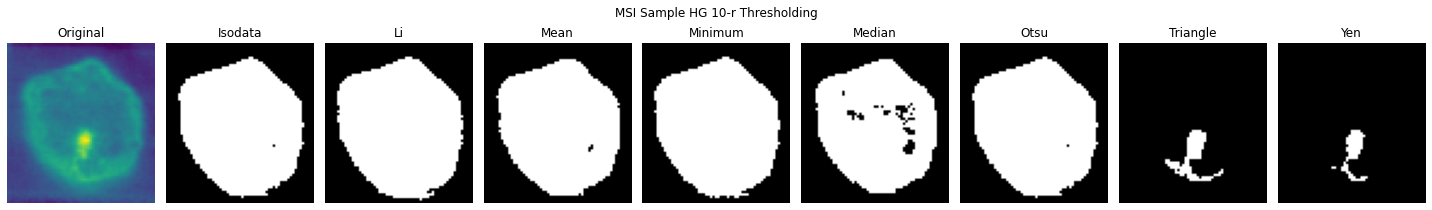

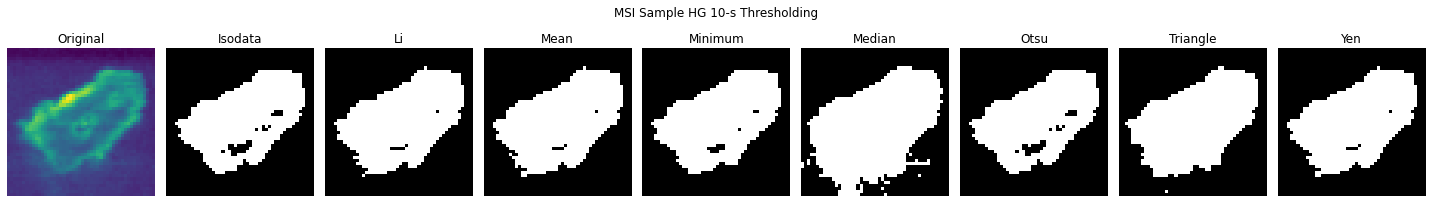

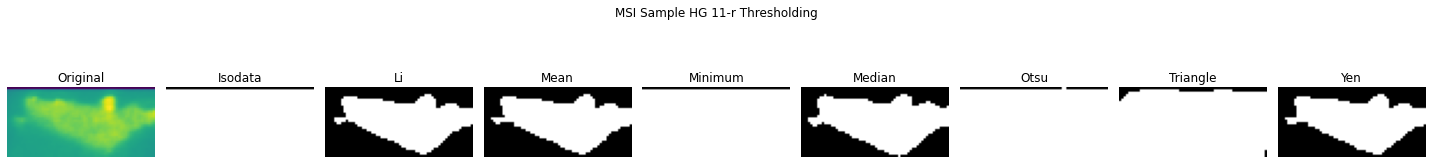

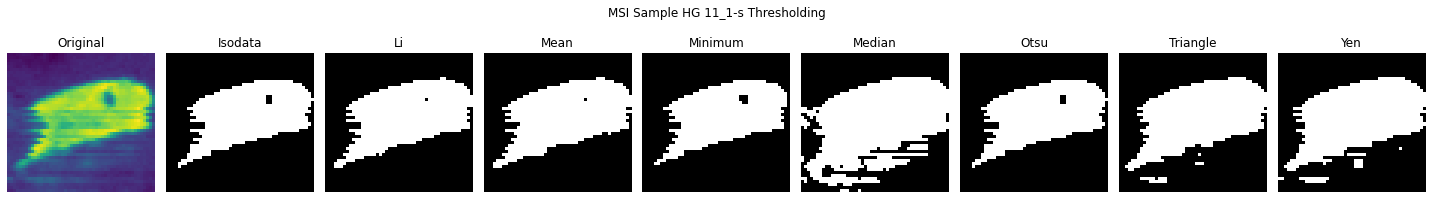

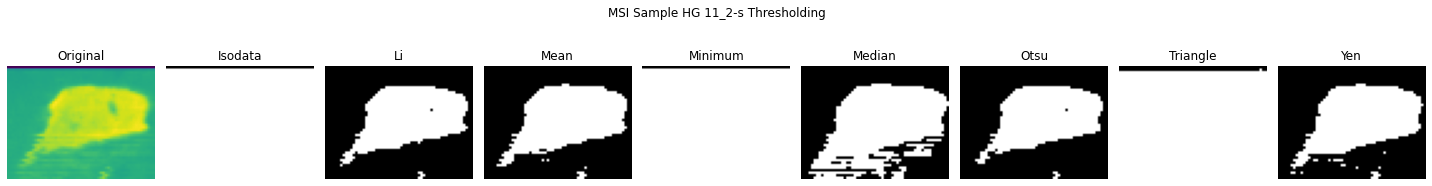

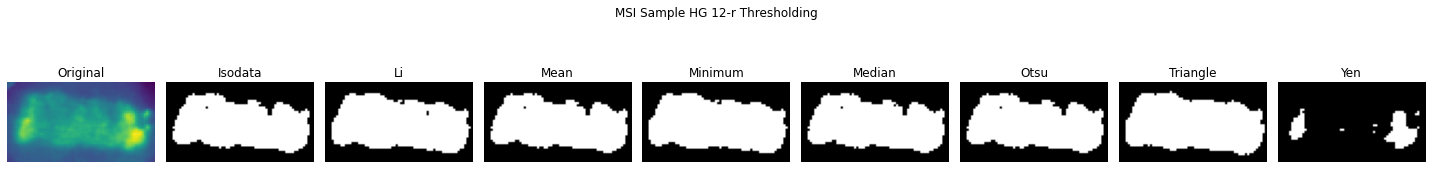

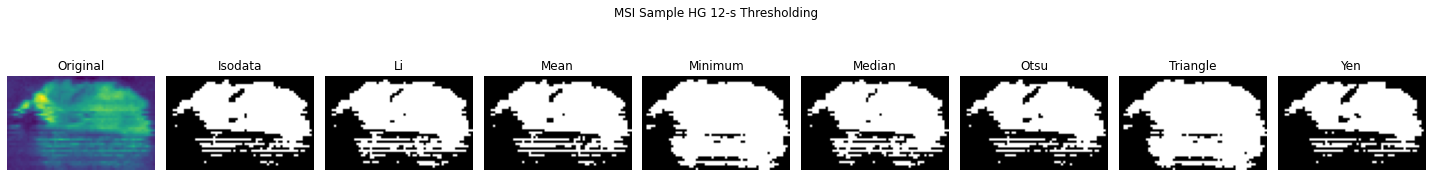

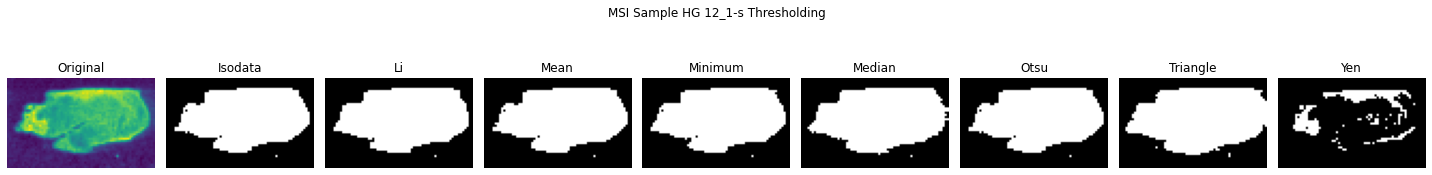

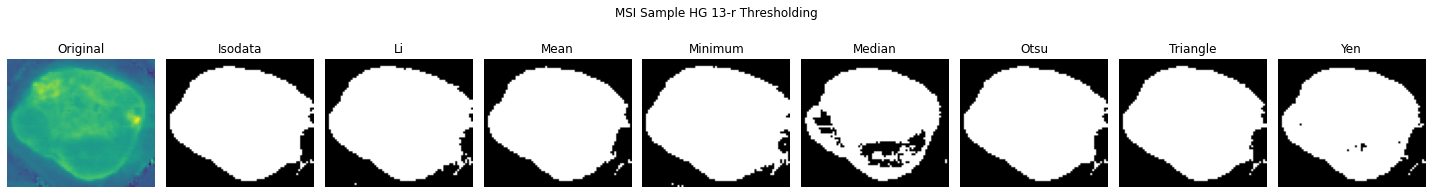

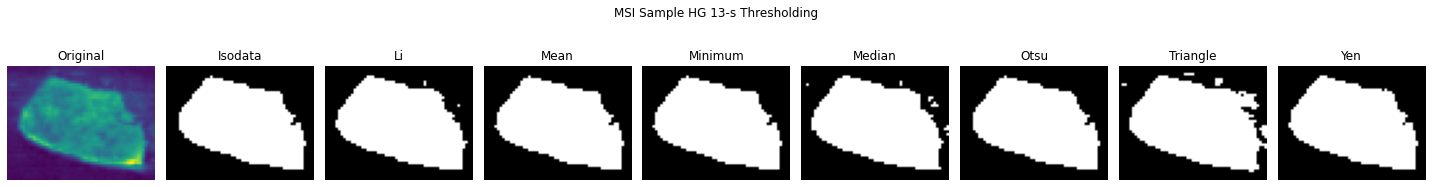

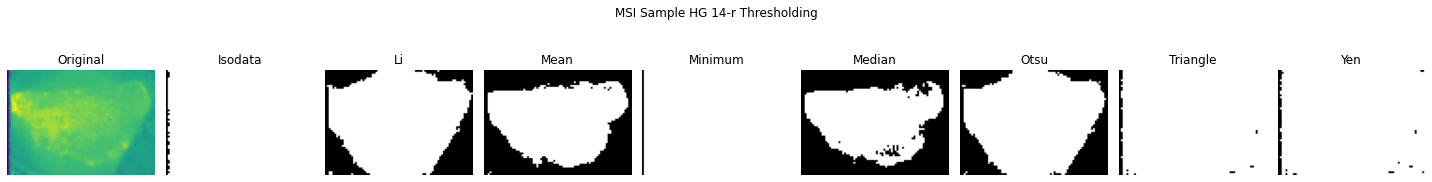

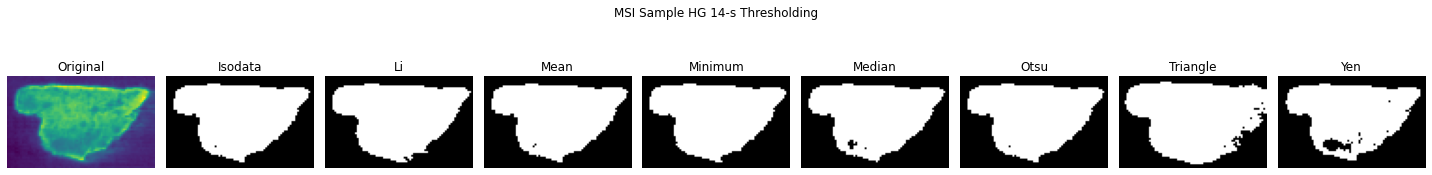

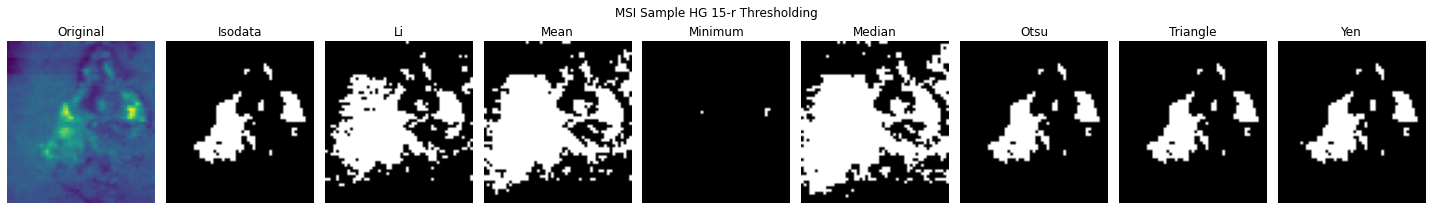

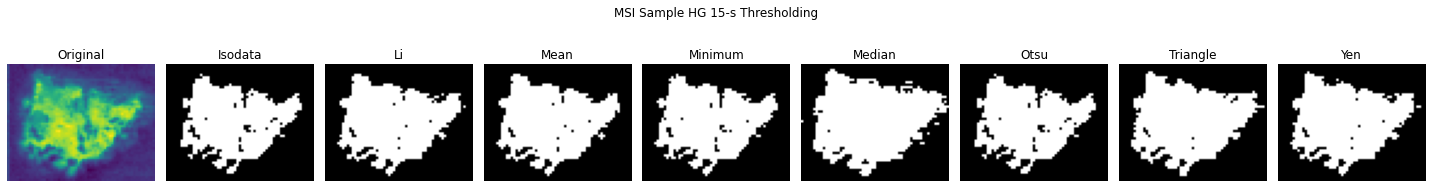

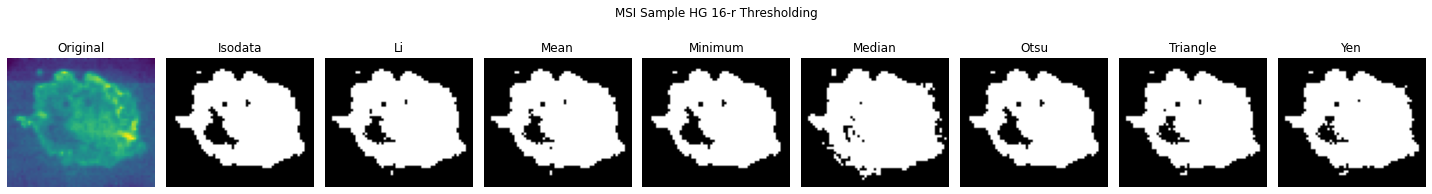

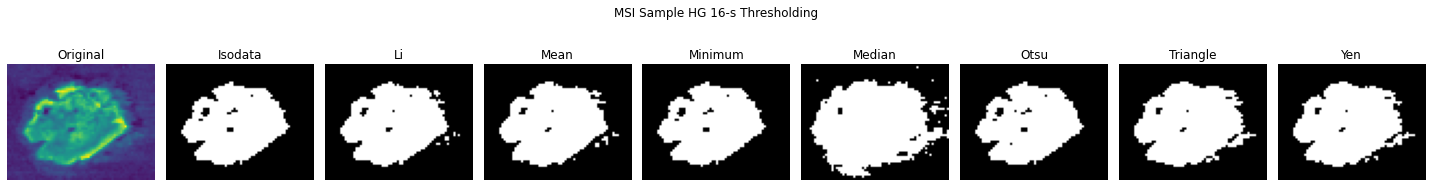

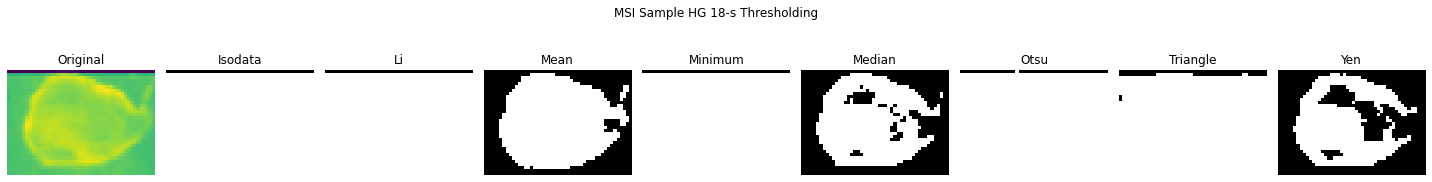

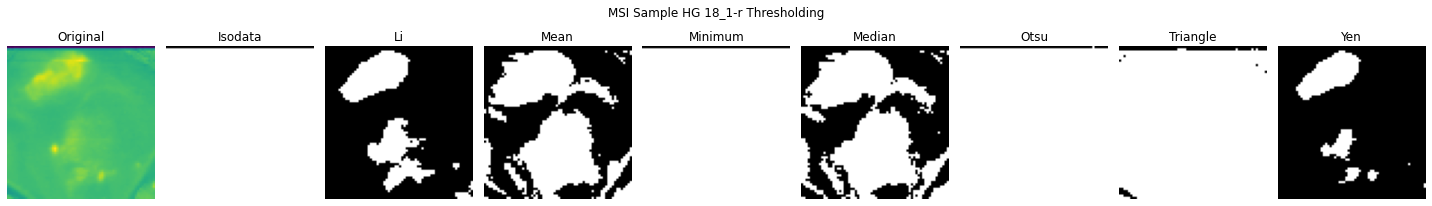

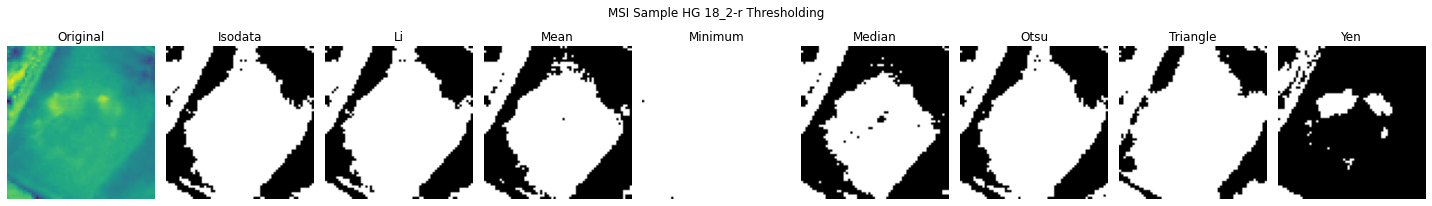

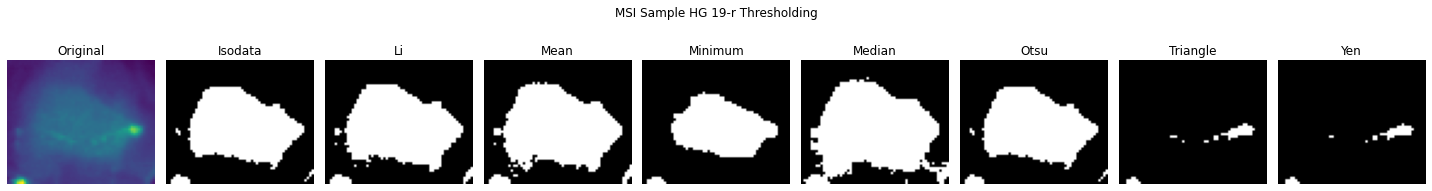

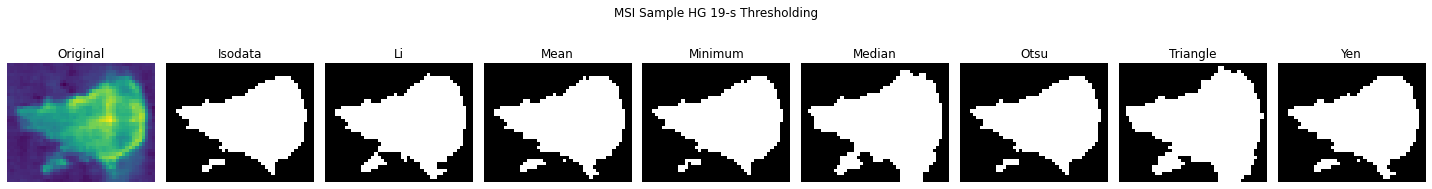

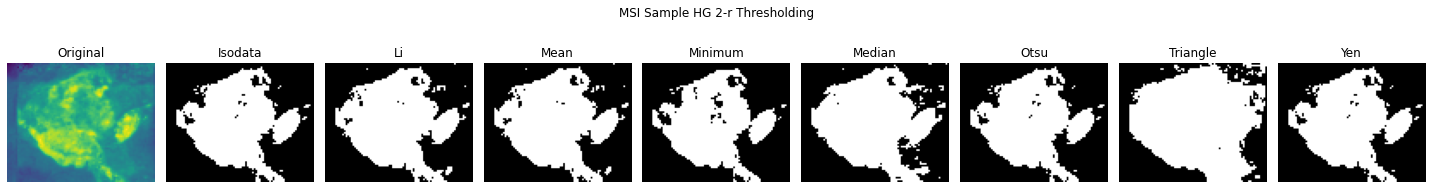

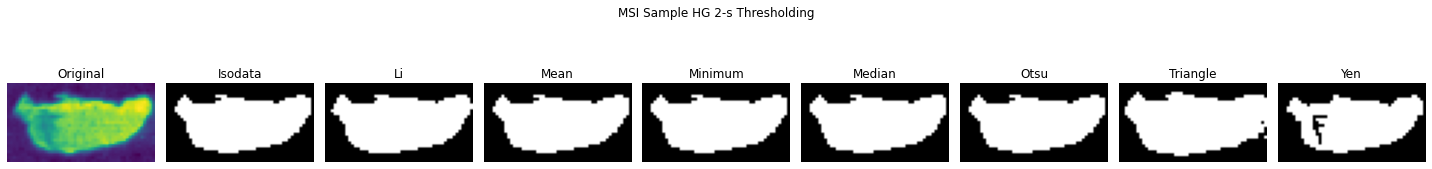

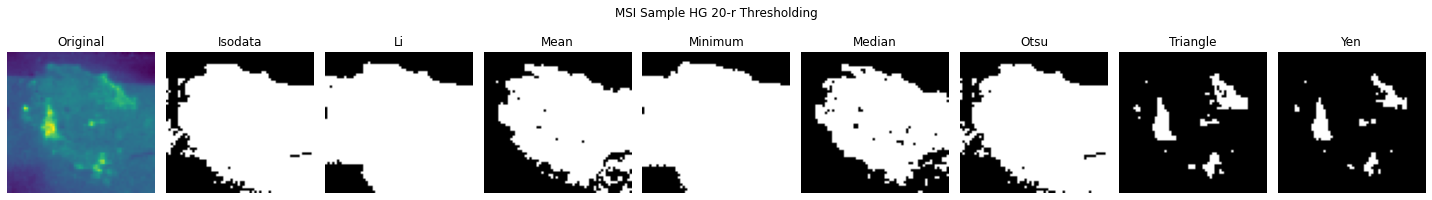

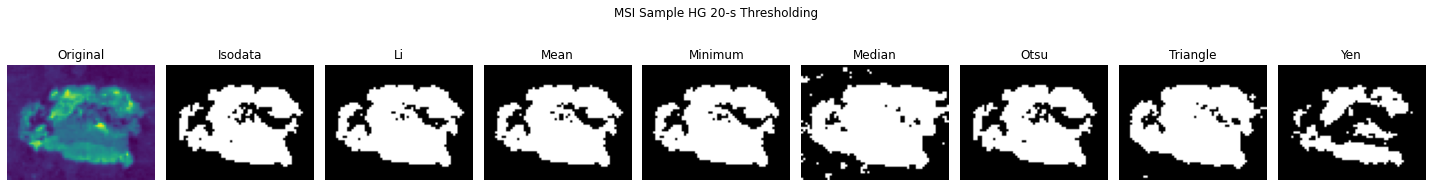

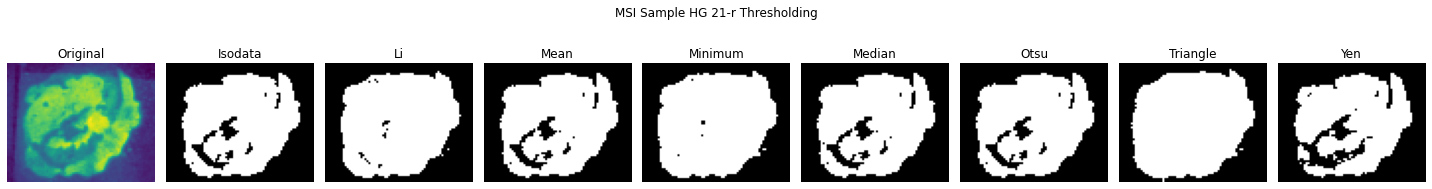

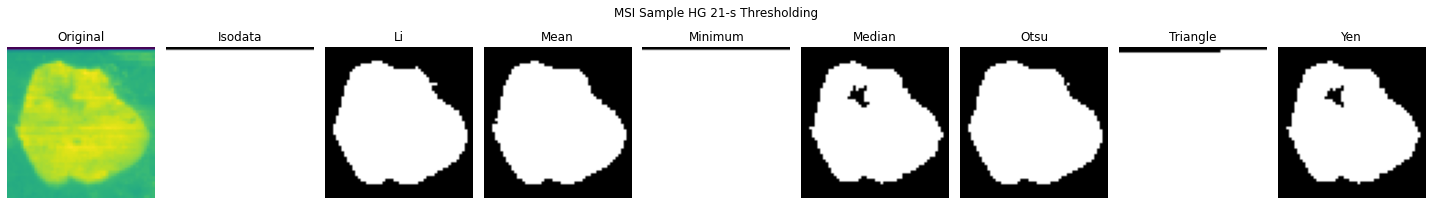

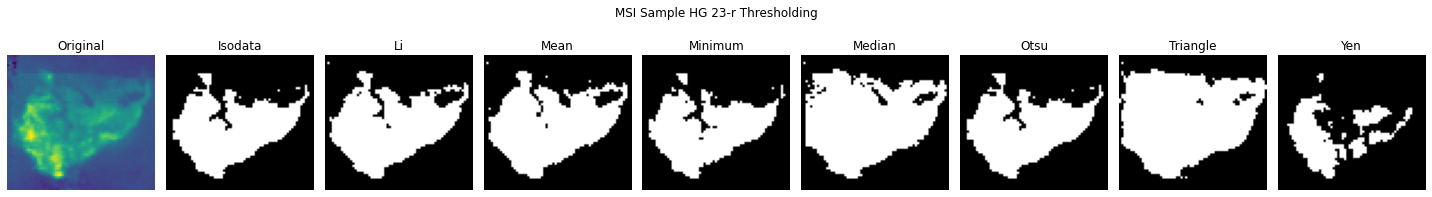

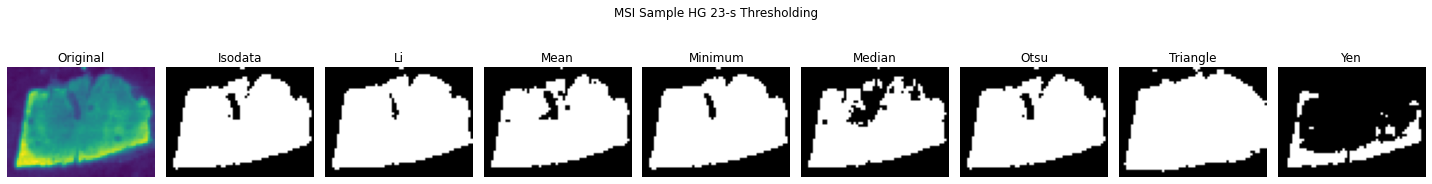

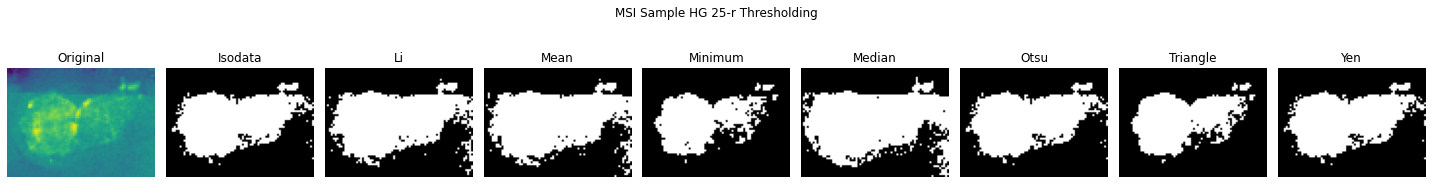

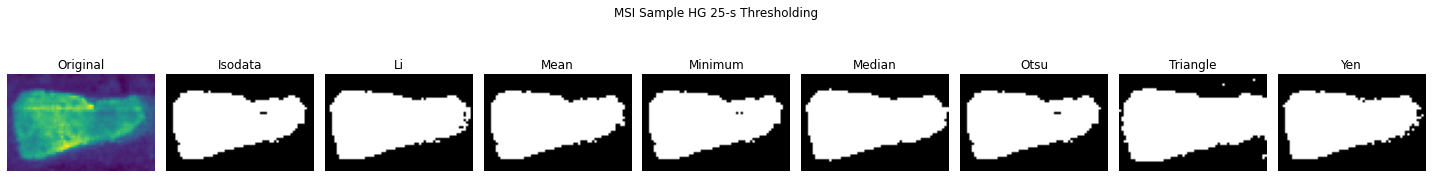

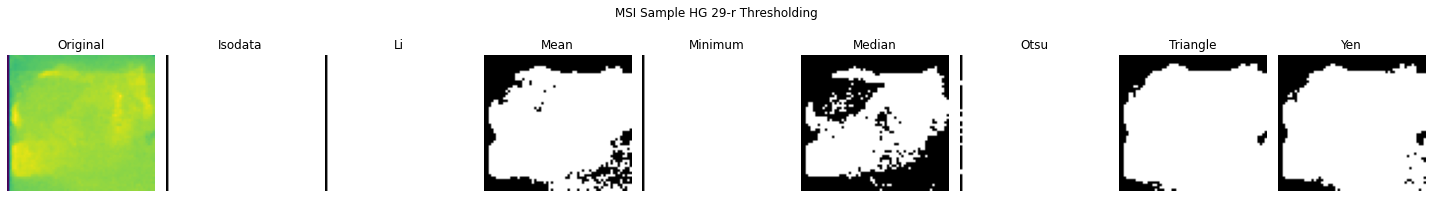

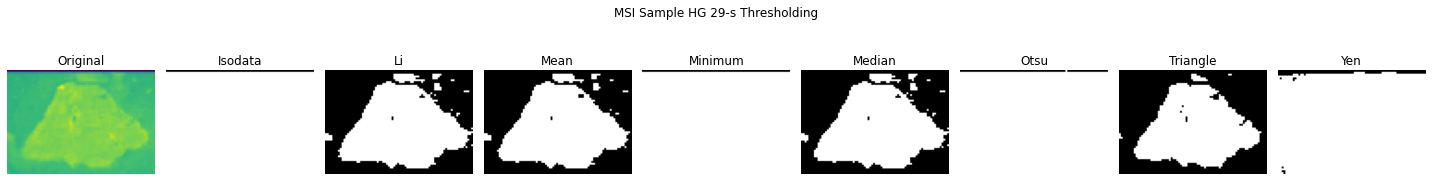

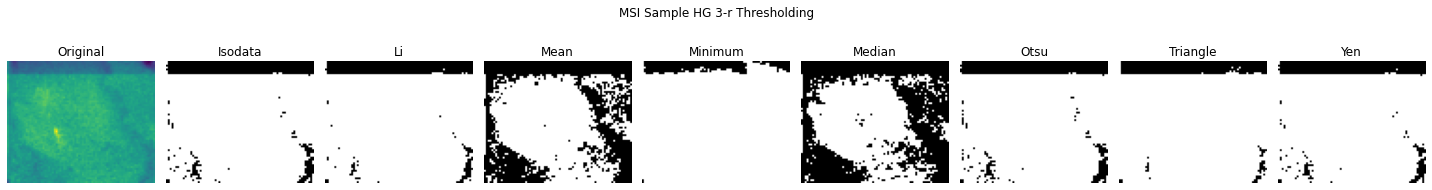

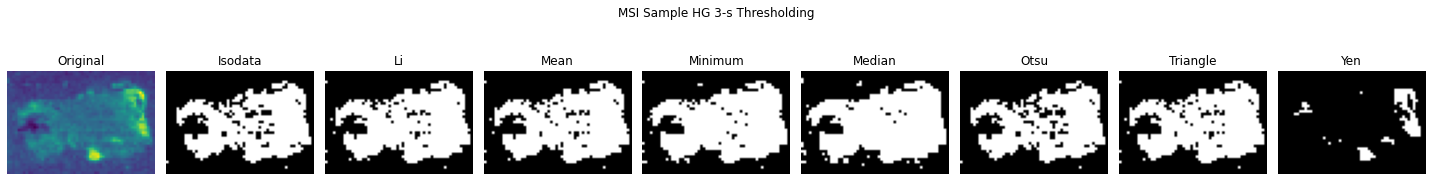

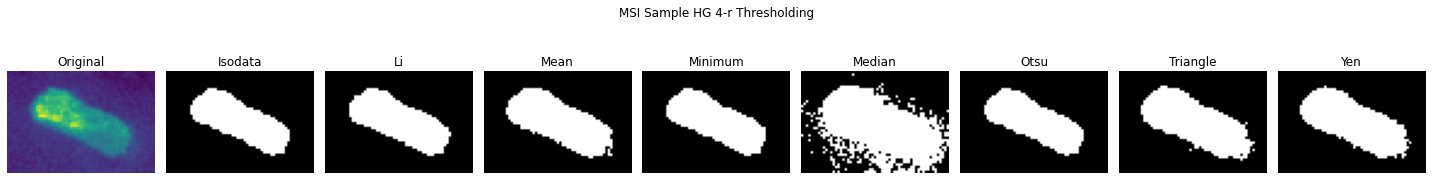

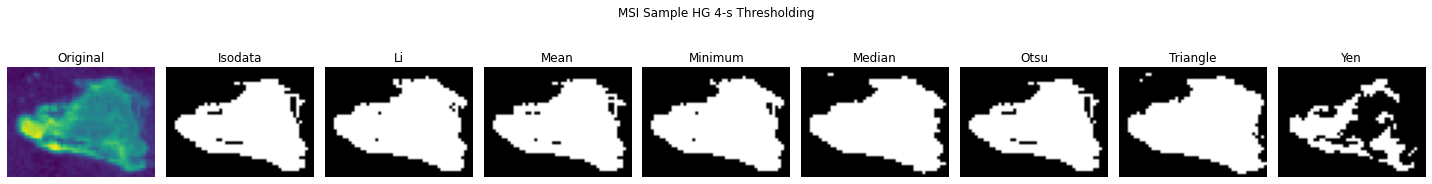

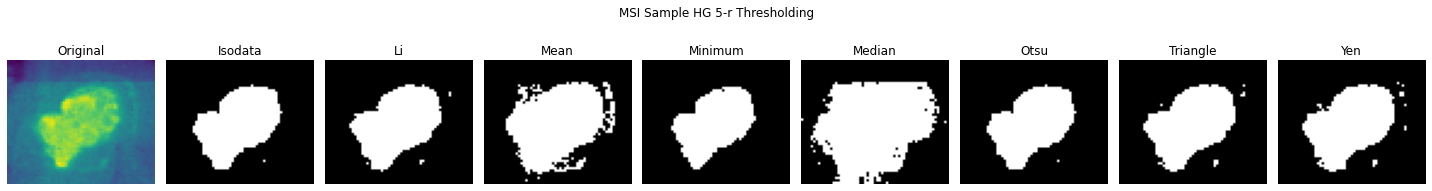

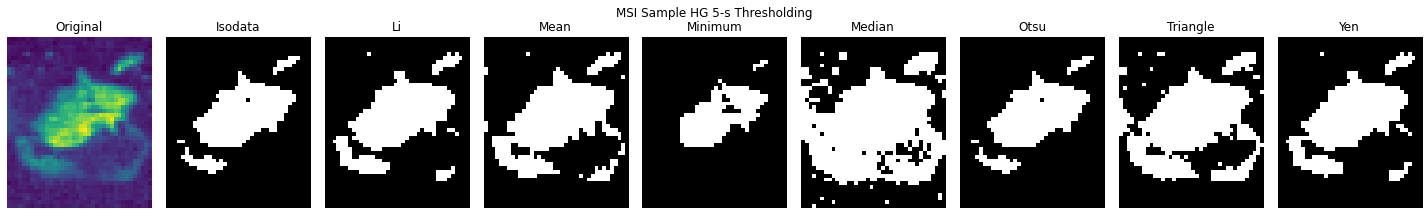

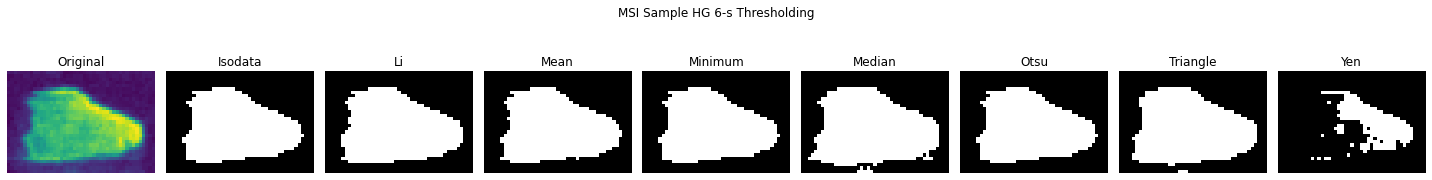

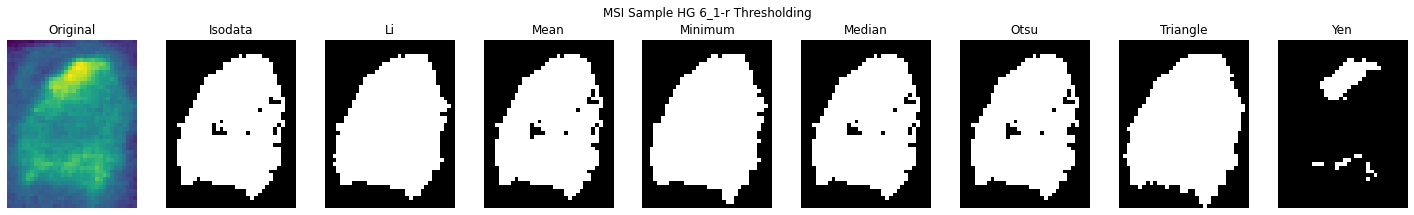

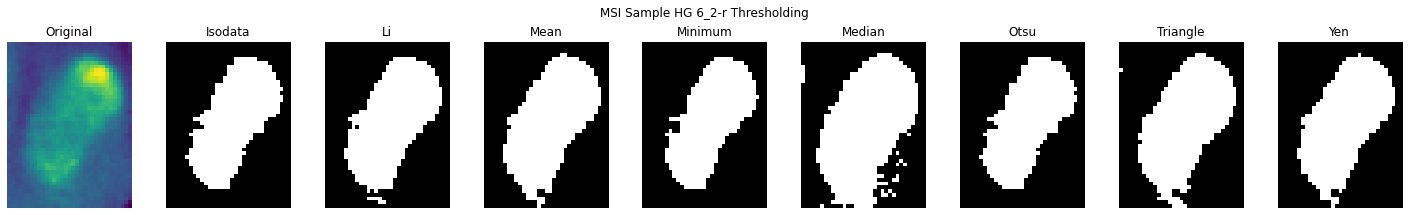

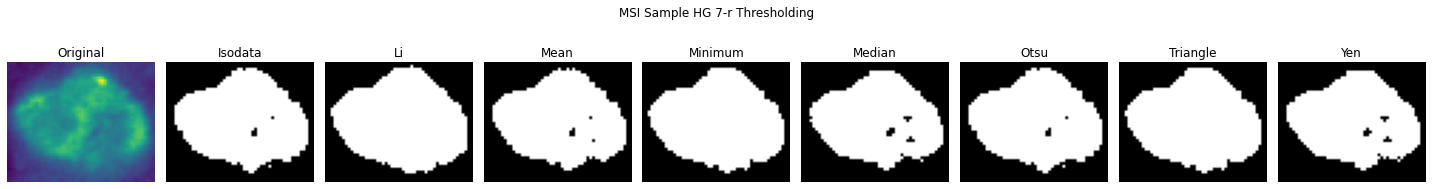

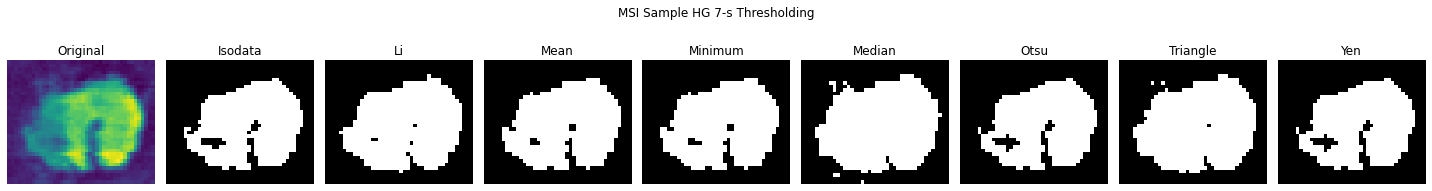

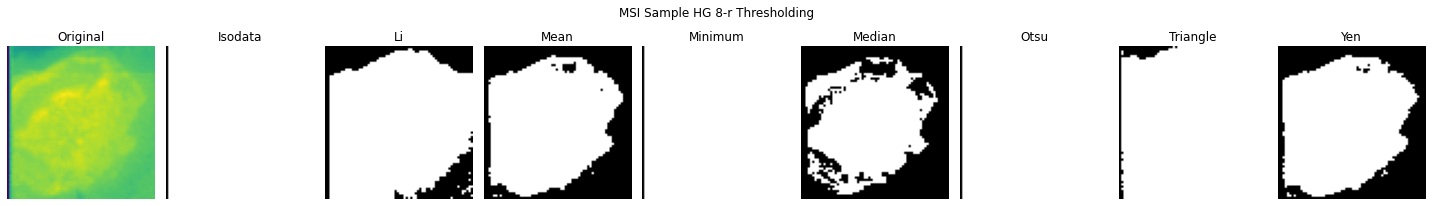

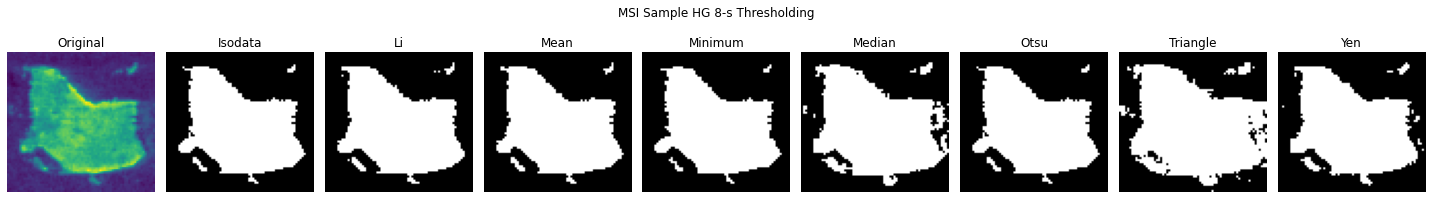

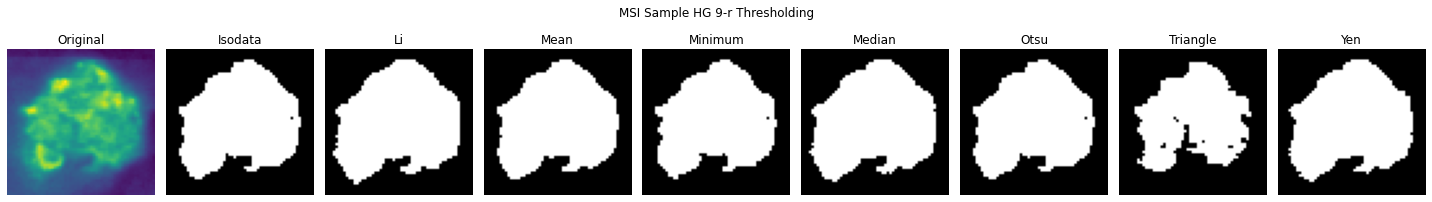

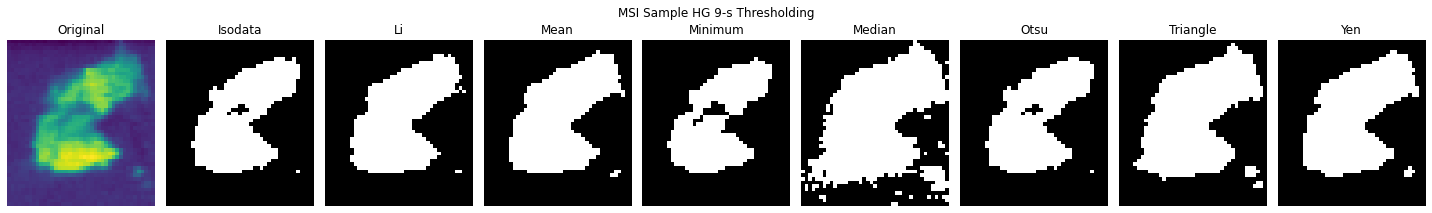

In [7]:
# Loop over each MSI name
for msi_name in msi_names:
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH, msi_name)) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Get local TIC image of msi in range [600, 900] (X region)
    local_tic_img = data[:, :, ((mzs > (TRESH_MZ - TRESH_MZ_TOL))) &
                         (mzs < (TRESH_MZ + TRESH_MZ_TOL))].sum(axis=-1)

    # Get all thresholding algorithms outputs
    fig, ax = try_all_threshold(local_tic_img, figsize=(20, 3))

    # plot thresholding algorithms outputs
    fig.suptitle(f"MSI Sample {msi_name.split('.')[0]} Thresholding")
    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_OUT_PATH}/{msi_name.split('.')[0]}_thresholding.png",
        transparent=True
    )
    plt.show()

    # Save data for plot creation
    np.savetxt(
        f"{PLOTS_OUT_PATH}/{msi_name.replace('.imzML', '')}_local_tic.csv",
        local_tic_img, delimiter=","
    )